In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, 
    BatchNormalization, Dropout, Input
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

CIFAR_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']
MODEL_PATH = "basic_cnn_model.h5"

In [2]:
print("Loading and preprocessing data...")

(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = cifar10.load_data()
x_full = np.concatenate((x_train_orig, x_test_orig), axis=0)
y_full = np.concatenate((y_train_orig, y_test_orig), axis=0)

x_full = x_full.astype('float32') / 255.0
y_full = to_categorical(y_full, 10)

x_train, x_temp, y_train, y_temp = train_test_split(
    x_full, y_full, test_size=0.30, random_state=42, stratify=y_full
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Data shapes:")
print(f"Train:      {x_train.shape} - {y_train.shape}")
print(f"Validation: {x_val.shape} - {y_val.shape}")
print(f"Test:       {x_test.shape} - {y_test.shape}")

Loading and preprocessing data...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 98s 1us/step
Data shapes:
Train:      (42000, 32, 32, 3) - (42000, 10)
Validation: (9000, 32, 32, 3) - (9000, 10)
Test:       (9000, 32, 32, 3) - (9000, 10)


In [3]:
def build_custom_cnn(input_shape=(32, 32, 3)):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model = build_custom_cnn()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 357,706 (1.36 MB)

 Trainable params: 357,258 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss')

print("Starting training...")
history = model.fit(
    x_train, y_train,
    epochs=50,
    validation_data=(x_val, y_val),
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
print(f"Training complete. Best model saved as '{MODEL_PATH}'")

Starting training...
Epoch 1/50
656/657 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3390 - loss: 1.9059

657/657 ━━━━━━━━━━━━━━━━━━━━ 73s 104ms/step - accuracy: 0.4099 - loss: 1.6521 - val_accuracy: 0.4539 - val_loss: 1.4534
Epoch 2/50
656/657 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5285 - loss: 1.3176

657/657 ━━━━━━━━━━━━━━━━━━━━ 66s 100ms/step - accuracy: 0.5487 - loss: 1.2668 - val_accuracy: 0.6408 - val_loss: 1.0268
Epoch 3/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 69s 105ms/step - accuracy: 0.6180 - loss: 1.0901 - val_accuracy: 0.5519 - val_loss: 1.4004
Epoch 4/50
656/657 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6578 - loss: 0.9792

657/657 ━━━━━━━━━━━━━━━━━━━━ 69s 104ms/step - accuracy: 0.6617 - loss: 0.9748 - val_accuracy: 0.7066 - val_loss: 0.8396
Epoch 5/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 83s 106ms/step - accuracy: 0.6949 - loss: 0.8777 - val_accuracy: 0.6911 - val_loss: 0.9413
Epoch 6/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 70s 106ms/step - accuracy: 0.7220 - loss: 0.8037 - val_accuracy: 0.6987 - val_loss: 0.9008
Epoch 7/50
656/657 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7495 - loss: 0.7188

657/657 ━━━━━━━━━━━━━━━━━━━━ 68s 103ms/step - accuracy: 0.7481 - loss: 0.7277 - val_accuracy: 0.7352 - val_loss: 0.7731
Epoch 8/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 70s 107ms/step - accuracy: 0.7670 - loss: 0.6728 - val_accuracy: 0.7143 - val_loss: 0.8592
Epoch 9/50
656/657 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7901 - loss: 0.5993

657/657 ━━━━━━━━━━━━━━━━━━━━ 72s 109ms/step - accuracy: 0.7849 - loss: 0.6167 - val_accuracy: 0.7460 - val_loss: 0.7639
Epoch 10/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 82s 109ms/step - accuracy: 0.8009 - loss: 0.5667 - val_accuracy: 0.7220 - val_loss: 0.9152
Epoch 11/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 64s 97ms/step - accuracy: 0.8145 - loss: 0.5259 - val_accuracy: 0.7423 - val_loss: 0.7698
Epoch 12/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 69s 104ms/step - accuracy: 0.8300 - loss: 0.4906 - val_accuracy: 0.7239 - val_loss: 0.8931
Epoch 13/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 80s 101ms/step - accuracy: 0.8391 - loss: 0.4561 - val_accuracy: 0.7398 - val_loss: 0.8697
Epoch 14/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 76s 92ms/step - accuracy: 0.8503 - loss: 0.4257 - val_accuracy: 0.7486 - val_loss: 0.8468
Training complete. Best model saved as 'basic_cnn_model.h5'


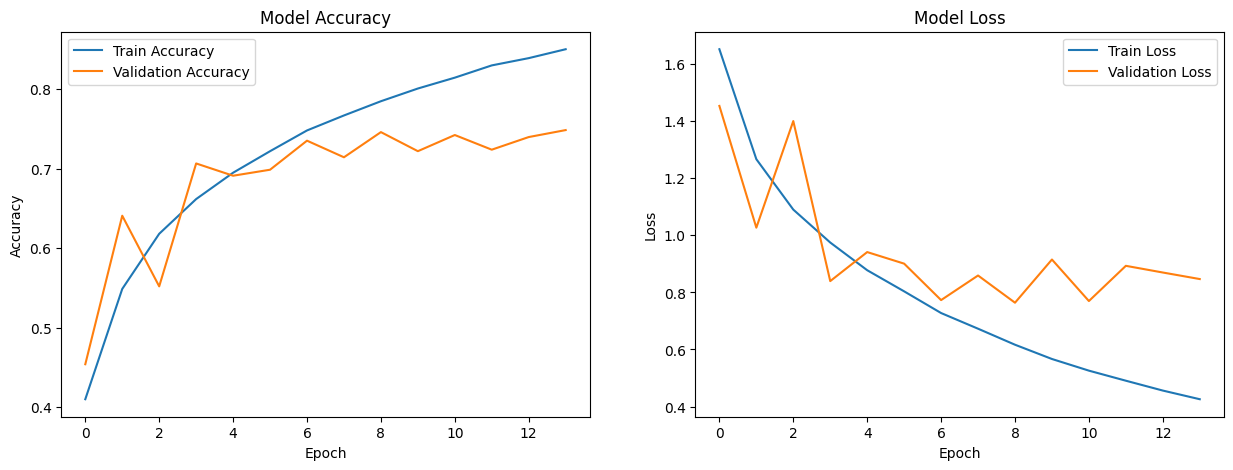

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.savefig("training_curves.png")
plt.show()

In [7]:
print("Loading best model from disk...")
model = load_model(MODEL_PATH)

print("Evaluating on test set...")
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {accuracy*100:.2f}%")
print(f"Final Test Loss: {loss:.4f}")

y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=CIFAR_CLASSES))

Loading best model from disk...


Evaluating on test set...

Final Test Accuracy: 75.02%
Final Test Loss: 0.7605
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step

Classification Report:
              precision    recall  f1-score   support

    airplane       0.82      0.75      0.78       900
  automobile       0.90      0.87      0.88       900
        bird       0.68      0.63      0.65       900
         cat       0.52      0.57      0.54       900
        deer       0.77      0.69      0.73       900
         dog       0.56      0.72      0.63       900
        frog       0.79      0.77      0.78       900
       horse       0.82      0.79      0.80       900
        ship       0.87      0.88      0.88       900
       truck       0.86      0.84      0.85       900

    accuracy                           0.75      9000
   macro avg       0.76      0.75      0.75      9000
weighted avg       0.76      0.75      0.75      9000



Plotting Confusion Matrix...


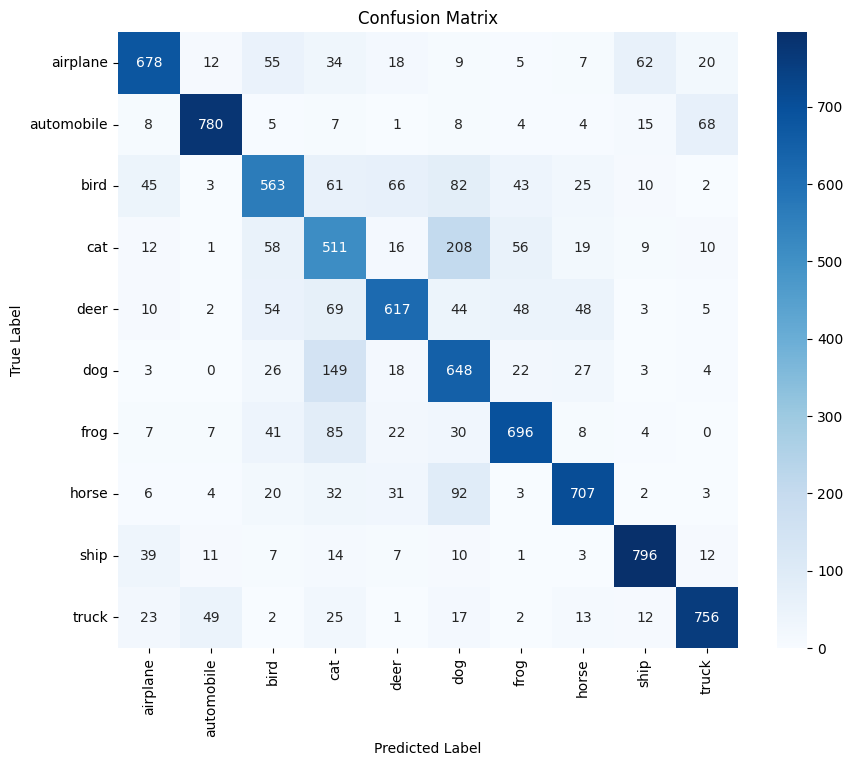

In [8]:
print("Plotting Confusion Matrix...")
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CIFAR_CLASSES, yticklabels=CIFAR_CLASSES)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.savefig("confusion_matrix.png")
plt.show()

Showing sample predictions (Green=Correct, Red=Incorrect)...


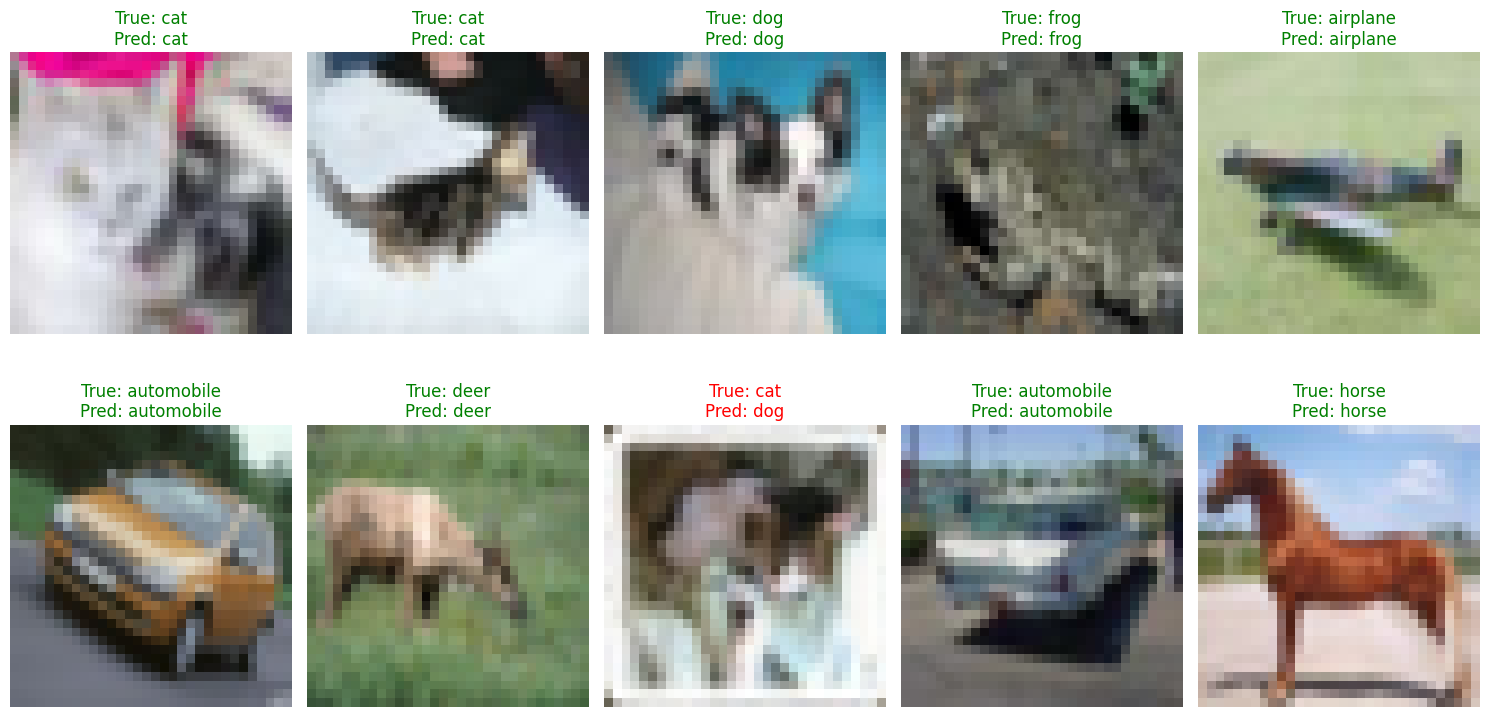

In [10]:
def show_sample_predictions(x_test, y_true, y_pred, n=10):
    plt.figure(figsize=(15, 8))
    for i in range(n):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(x_test[i])
        true_label = CIFAR_CLASSES[y_true[i]]
        pred_label = CIFAR_CLASSES[y_pred[i]]
        
        title_color = 'green' if true_label == pred_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
        plt.axis("off")
    plt.tight_layout()
    plt.savefig("sample_predictions.png")
    plt.show()

print("Showing sample predictions (Green=Correct, Red=Incorrect)...")
show_sample_predictions(x_test, y_true_classes, y_pred_classes, n=10)